# Noise Mismodeling for Modulated Noise Processes

## Overview

This notebook investigates the impact of noise mismodeling when analyzing gravitational wave signals in the presence of time-dependent amplitude modulation. Unlike gaps which introduce discontinuities, amplitude modulation via $w(t) = A + B\cos(2\pi t/T_{\text{obs}})$ creates a smooth non-stationary noise process.

## Key Question

**How does assuming stationary noise (diagonal covariance) when the true noise is modulated (non-diagonal covariance) affect parameter estimation and SNR calculations?**

## Mathematical Framework

For modulated data in the time domain:
$$D(t) = w(t)d(t) = w(t)n(t) + w(t)h(t) = N(t) + H(t)$$

The true noise covariance matrix for both positive and negative frequencies is:
$$\Sigma_{N,ij} = \Delta f\sum_{p}\tilde{w}^{\star}(f_{i} - v_{p})\tilde{w}(f_{j} - v_{p})S_{n}(v_{p})$$

where:
- $N$ is the length of the signal in the time domain (assumed even)
- $\Delta f = 1/(N\Delta t) = 1/T_{\text{obs}}$ is the frequency spacing
- $\tilde{w}$ is the DFT of the modulation function $w(t)$
- $S_{n}(v_{p})$ is the power spectral density at frequency $v_{p}$

The log-likelihood is:
$$\log L(D|\theta) = -\frac{1}{2}(\boldsymbol{\tilde{D}} - \boldsymbol{\tilde{H}})^{\dagger}\Sigma_{N}^{-1}(\boldsymbol{\tilde{D}} - \boldsymbol{\tilde{H}}) + \text{const}$$

The optimal matched filtering SNR is:
$$\rho^{2} = \boldsymbol{\tilde{h}}^{\dagger} \Sigma_{N}^{-1} \boldsymbol{\tilde{h}}$$

## Notebook Goals

1. Generate modulated noise using $w(t) = A + B\cos(2\pi t/T_{\text{obs}})$
2. Compute non-diagonal noise covariance matrix $\Sigma_N$ for TDI1 and TDI2
3. Compare SNR using correct vs mismodeled (stationary) covariance
4. Evaluate likelihood and parameter estimation with/without proper modeling
5. Monte Carlo analysis: average over many noise realizations to assess bias and precision

In [88]:
from scipy.signal.windows import tukey
import numpy as np
import matplotlib.pyplot as plt
from numba import njit, prange
from tqdm import tqdm

import warnings
%matplotlib inline
warnings.filterwarnings("ignore")

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


# Function Definitions

In [89]:
def h(a, f0, fdot0, t, w_t=1.0):
    """
    Generate gravitational wave signal with chirping frequency.
    
    Parameters:
    - a: amplitude
    - f0: initial frequency [Hz]
    - fdot0: frequency derivative [Hz/s]
    - t: time array [s]
    - w_t: modulation window function (default=1.0)
    
    Returns:
    - Waveform time series
    """
    return w_t * 3e-22 * (a * np.sin((2*np.pi)*t*(f0 + fdot0 * t)))


def modulation(A, B, OMEGA, t, T_obs):
    """
    Generate cosine amplitude modulation.
    
    Parameters:
    - A: baseline amplitude
    - B: modulation depth
    - t: time array [s]
    - T_obs: observation time [s]
    
    Returns:
    - Modulation function w(t) = A + B*cos(2πt/T_obs)
    """
    return A + B * np.cos(2 * np.pi * OMEGA * t / T_obs)


def noise_PSD(f, TDI='TDI1'):
    """
    LISA noise power spectral density for different TDI channels.
    
    Parameters:
    - f: frequency array [Hz]
    - TDI: 'TDI1' or 'TDI2'
    
    Returns:
    - Power spectral density [strain²/Hz]
    """
    L = 2.5e9  # LISA arm length [m]
    c = 299792458  # speed of light [m/s]
    x = 2*np.pi*(L/c)*f
    
    # Acceleration noise
    Spm = (3e-15)**2 * (1 + ((4e-4)/f)**2) * (1 + (f/(8e-3))**4) * \
          (1/(2*np.pi*f))**4 * (2*np.pi*f/c)**2
    
    # Optical metrology noise
    Sop = (15e-12)**2 * (1 + ((2e-3)/f)**4) * ((2*np.pi*f)/c)**2
    
    S_val = (2*Spm*(3 + 2*np.cos(x) + np.cos(2*x)) + Sop*(2 + np.cos(x)))
    
    if TDI == 'TDI1':
        # Red noise at low frequencies
        S = 8*(np.sin(x)**2) * S_val
    elif TDI == 'TDI2':
        # White noise at low frequencies, stronger violet noise
        S = 32*np.sin(x)**2 * np.sin(2*x)**2 * S_val
    else:
        raise ValueError("TDI must be 'TDI1' or 'TDI2'")
    
    return S


def zero_pad(data):
    """
    Zero-pad data to next power of 2 for efficient FFT.
    
    Parameters:
    - data: input array
    
    Returns:
    - Zero-padded array with length 2^n
    """
    N = len(data)
    pow_2 = np.ceil(np.log2(N))
    return np.pad(data, (0, int((2**pow_2) - N)), 'constant')


print("✓ Signal and noise functions defined")

✓ Signal and noise functions defined


# Covariance Matrix Computation Functions

In [90]:
@njit(parallel=True) 
def compute_covariance_slow(Cov, w_fft, PSD, Delta_f):
    """
    Compute N×N Fourier-domain covariance matrix for windowed process (slow version).
    
    Uses nested loops with Numba JIT compilation for verification purposes.
    
    Parameters:
    - Cov: preallocated N×N array
    - w_fft: FFT of window function (two-sided, fftshifted)
    - PSD: power spectral density (two-sided, fftshifted)
    - Delta_f: frequency resolution
    
    Returns:
    - Cov: filled covariance matrix
    """
    N = len(w_fft)
    w_fft_conj = w_fft.conj()
    
    # Compute upper triangle (including diagonal)
    for i in prange(N):
        for j in range(i, N):
            result = 0
            for p in range(N):
                index_i = (i - p) % N
                index_j = (j - p) % N
                index_PSD = (p + N//2) % N                
                result += w_fft[index_i] * w_fft_conj[index_j] * PSD[index_PSD]
                
            Cov[i, j] = result
            Cov[j, i] = np.conjugate(Cov[i, j])
    
    Cov *= Delta_f
    return Cov


def noise_covariance_w_pos(Sn, w, Deltat, diag = "all"):
    '''
    Compute N*N Fourier-domain covariance matrix for windowed process

    Fourier convention: standard, \tilde{F}(f) = \int dt e^{-2 i pi f t}F(t)

    Args:
      Sn      # Values of PSD Sn(i Deltaf), i=0,...,N/2 included (size N/2+1)
      w       # Values of window w(i Deltat), i=0,...,N-1 (size N)
      Deltat  # Value of time interval (Deltaf = 1/(N Deltat))
    '''

    N = len(w)
    M = N//2 + 1
    Deltaf = 1./(N*Deltat)


    w_tilde = np.fft.rfft(w)
    u_tilde = np.fft.fft(Sn[::-1])
    
    rangeM = np.arange(M)

    Sigma_tilde_w = np.zeros((M,M), dtype=complex)
    # Compute both upper and lower diagonals (in the circulant sense, with periodicity)
    # try:
    if diag == "all":
        diag_range = range(M//2 + 1)
    elif np.issubdtype(type(diag), np.integer):
        diag_range = range(diag//2 + 1)
    for diag_index in diag_range:
        v = w_tilde * np.conj(np.roll(w_tilde, -diag_index))
        v_tilde = np.fft.fft(v)
        diag_vals =  (Deltaf/2) * np.fft.ifft(u_tilde * v_tilde)
        diag_vals_rolled = np.roll(diag_vals[0:M],diag_index)[::-1]
        Sigma_tilde_w[np.roll(rangeM, -diag_index), rangeM] = diag_vals_rolled

    np.fill_diagonal(Sigma_tilde_w, 0.5 * np.real(Sigma_tilde_w.diagonal()))

    Sigma_tilde_w = Sigma_tilde_w + Sigma_tilde_w.T.conj()

    return Sigma_tilde_w


def noise_covariance_modulation_analytical(Sn, A, B, Omega, Deltat):
    """
    Analytical noise covariance for modulation w(t) = A + B*cos(2*pi*Omega*t/T_obs).
    
    Matches the normalization convention of noise_covariance_w_pos.
    """
    import warnings
    
    M = len(Sn)
    N = 2 * (M - 1)
    
    k = int(np.round(Omega))
    if np.abs(Omega - k) > 1e-6:
        warnings.warn(f"Omega={Omega:.6f} not integer. Using k={k}")
    if k >= M:
        raise ValueError(f"Omega={Omega} too large (k >= M={M})")
    
    Sigma = np.zeros((M, M), dtype=float)
    
    # Normalization factor to match FFT convention
    norm = N / (2 * Deltat)
    
    # Diagonal
    Sigma[np.arange(M), np.arange(M)] = (A**2 + B**2/2.0) * norm * Sn
    
    if k > 0:
        # First sidebands
        i = np.arange(M - k)
        j = i + k
        term1 = A * B * norm * Sn[i]
        term2 = np.zeros(len(j))
        valid = j >= 2*k
        term2[valid] = (B**2/4.0) * norm * Sn[j[valid] - 2*k]
        
        Sigma[i, j] = term1 + term2
        Sigma[j, i] = term1 + term2
        
        # Second sidebands
        if 2*k < M:
            i2 = np.arange(M - 2*k)
            j2 = i2 + 2*k
            val = (B**2/4.0) * norm * Sn[i2]
            Sigma[i2, j2] = val
            Sigma[j2, i2] = val
    
    return Sigma
print("✓ Covariance computation functions defined over positive frequencies")

✓ Covariance computation functions defined over positive frequencies


# Setup: Time Series and Modulation Parameters

In [112]:
# Time series parameters
tmax = 30 * 60 * 60  # 30 hours observation
fmax = 1e-7 * 1 * tmax
fs = 2 * fmax
delta_t = np.floor(0.7 / fs)

# Generate time array
t = np.arange(0, tmax, delta_t)
N = int(2 ** (np.ceil(np.log2(len(t)))))
t_pad = np.arange(0, N * delta_t, delta_t)
T_obs = N * delta_t

# Modulation parameters
A = 1.25    # Baseline amplitude
B = -0.5    # Modulation depth (50% variation)
OMEGA = 2.0

# Generate modulation function
w_t = modulation(A, B, OMEGA, t_pad, T_obs)
# Frequency domain setup
freq_bin = np.fft.rfftfreq(N, delta_t)
delta_f = freq_bin[1] - freq_bin[0]
freq_bin[0] = freq_bin[1]
print(f"Observation parameters:")
print(f"  Total time: {T_obs/3600:.2f} hours")
print(f"  Samples: N = {N:,}")
print(f"  Time resolution: Δt = {delta_t:.1f} s")
print(f"  Frequency resolution: Δf = {delta_f:.2e} Hz")
print(f"\nModulation parameters:")
print(f"  A = {A}, B = {B}")
print(f"  Modulation range: [{A-B:.1f}, {A+B:.1f}]")
print(f"  Modulation period: {T_obs/3600:.2f} hours")

Observation parameters:
  Total time: 36.41 hours
  Samples: N = 4,096
  Time resolution: Δt = 32.0 s
  Frequency resolution: Δf = 7.63e-06 Hz

Modulation parameters:
  A = 1.25, B = -0.5
  Modulation range: [1.8, 0.8]
  Modulation period: 36.41 hours


# Visualize Modulation Function

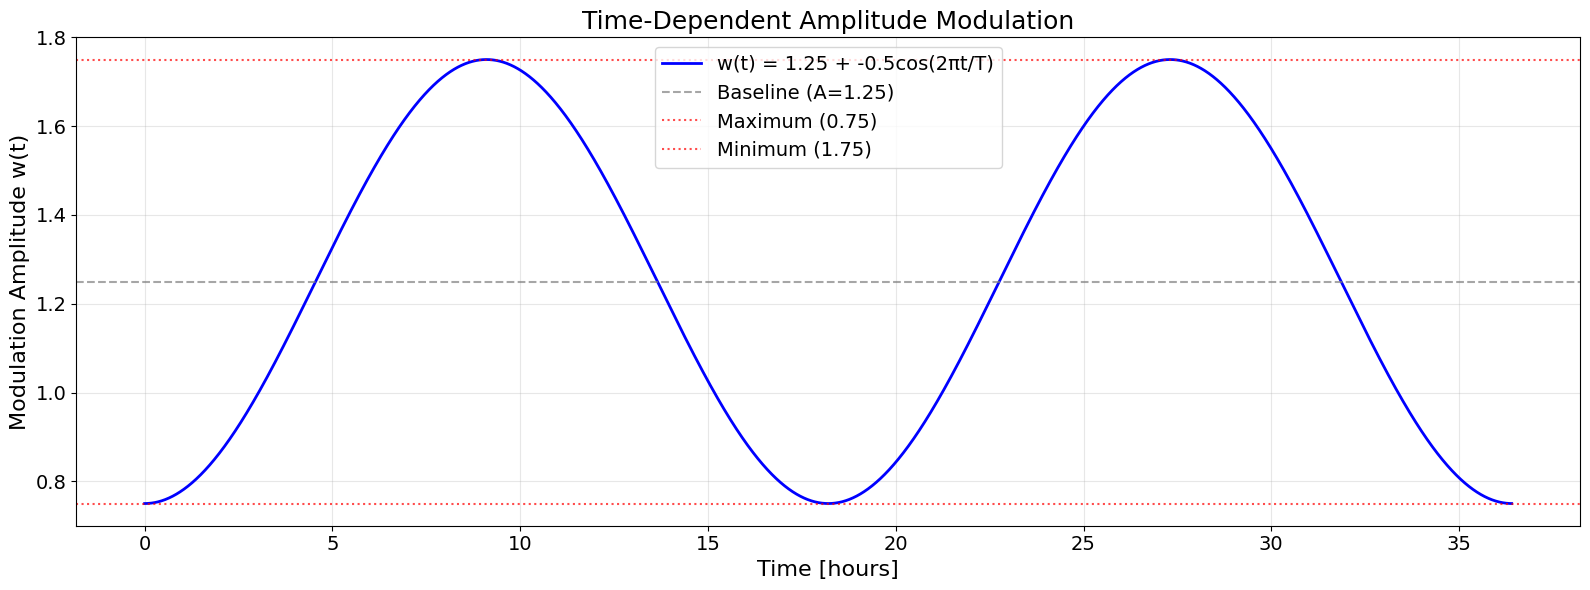

✓ Modulation spans 36.4 hours with amplitude variation: ±-40%


In [113]:
fig, ax = plt.subplots(1, 1, figsize=[16, 6])

ax.plot(t_pad / 3600, w_t, 'b-', linewidth=2, label=f'w(t) = {A} + {B}cos(2πt/T)')
ax.axhline(y=A, color='gray', linestyle='--', alpha=0.7, label=f'Baseline (A={A})')
ax.axhline(y=A+B, color='red', linestyle=':', alpha=0.7, label=f'Maximum ({A+B})')
ax.axhline(y=A-B, color='red', linestyle=':', alpha=0.7, label=f'Minimum ({A-B})')

ax.set_xlabel('Time [hours]', fontsize=16)
ax.set_ylabel('Modulation Amplitude w(t)', fontsize=16)
ax.set_title('Time-Dependent Amplitude Modulation', fontsize=18)
ax.grid(True, alpha=0.3)
ax.legend(fontsize=14)
ax.tick_params(labelsize=14)

plt.tight_layout()
plt.show()

print(f"✓ Modulation spans {T_obs/3600:.1f} hours with amplitude variation: ±{B/A*100:.0f}%")

# Signal Parameters and Waveform Generation

In [114]:
# Signal parameters (same as gaps notebook)
a_ex = 1.0         # Amplitude
f0_ex = 5e-3       # Initial frequency [Hz]
fdot0_ex = 1e-8    # Frequency derivative [Hz/s]

# Generate true signal WITHOUT modulation (for reference)
signal_true_pad = h(a_ex, f0_ex, fdot0_ex, t_pad, w_t=1.0)
signal_true_fft = np.fft.rfft(signal_true_pad)

print(f"Signal parameters:")
print(f"  Amplitude: a = {a_ex}")
print(f"  Initial frequency: f0 = {f0_ex*1e3:.2f} mHz")
print(f"  Chirp rate: fdot0 = {fdot0_ex:.2e} Hz/s")
print(f"\n✓ Signal generated)")

Signal parameters:
  Amplitude: a = 1.0
  Initial frequency: f0 = 5.00 mHz
  Chirp rate: fdot0 = 1.00e-08 Hz/s

✓ Signal generated)


# Visualize Signal in Time and Frequency Domain

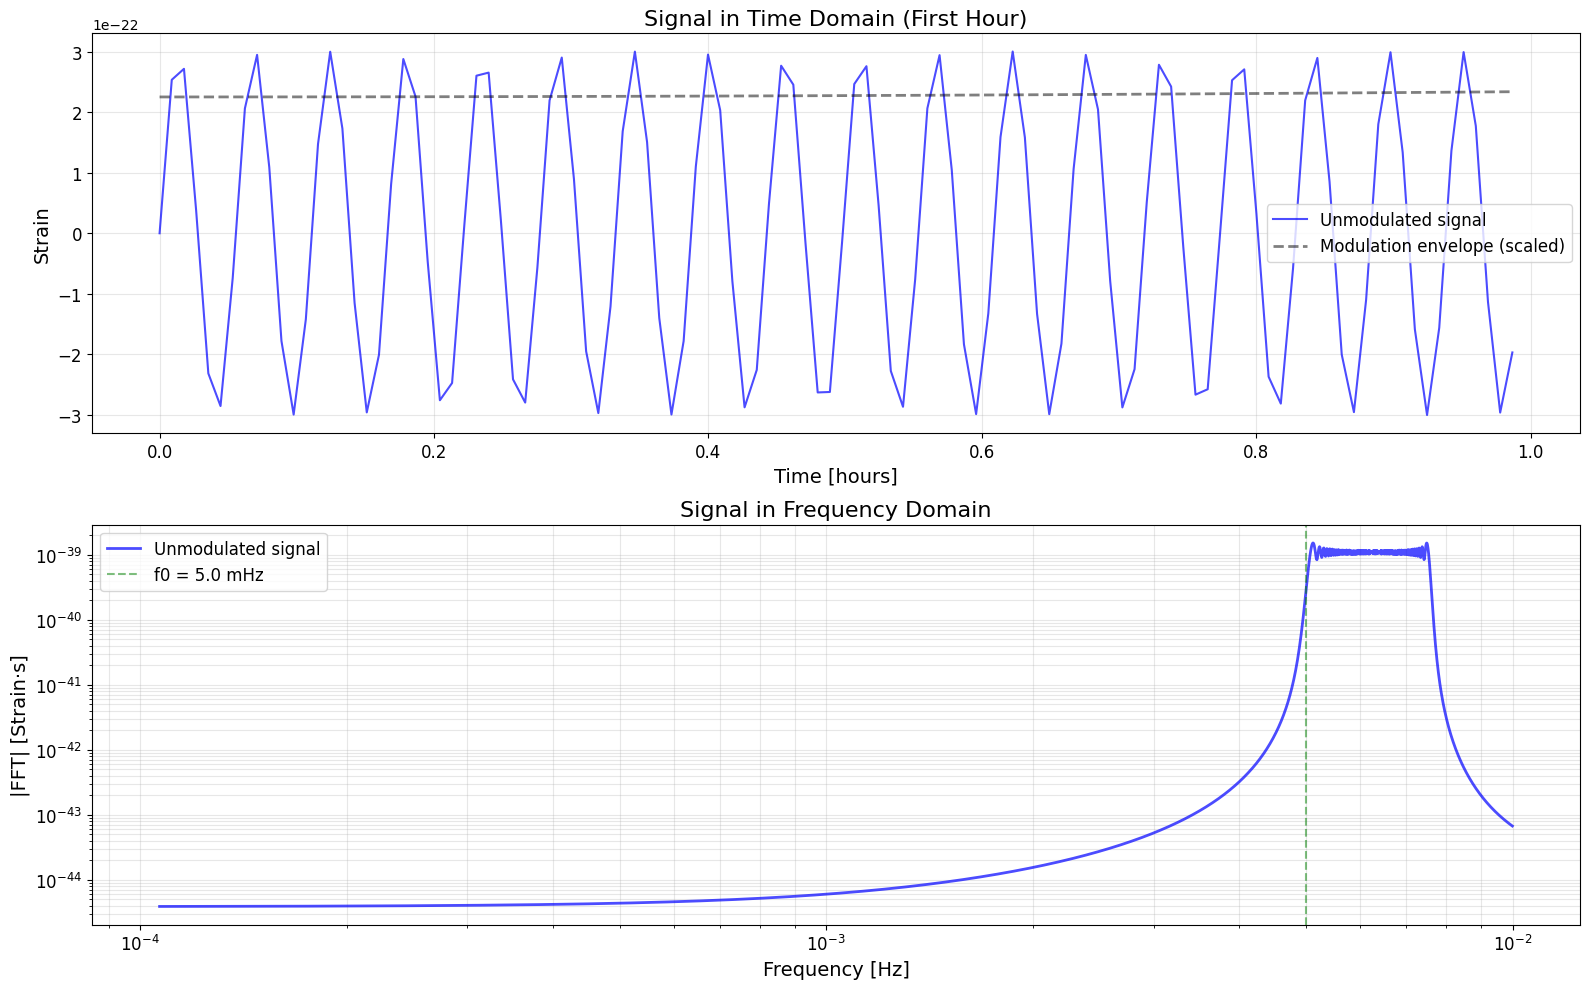

✓ Modulation creates spectral sidebands around the carrier frequency


In [115]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=[16, 10])

# Time domain - zoom in on first hour
one_hour = int(3600 / delta_t)
time_hr = t_pad[:one_hour] / 3600

ax1.plot(time_hr, signal_true_pad[:one_hour], 'b-', alpha=0.7, linewidth=1.5, label='Unmodulated signal')
ax1.plot(time_hr, w_t[:one_hour] * np.max(np.abs(signal_true_pad[:one_hour])), 'k--', alpha=0.5, linewidth=2, label='Modulation envelope (scaled)')
ax1.set_xlabel('Time [hours]', fontsize=14)
ax1.set_ylabel('Strain', fontsize=14)
ax1.set_title('Signal in Time Domain (First Hour)', fontsize=16)
ax1.legend(fontsize=12)
ax1.grid(True, alpha=0.3)
ax1.tick_params(labelsize=12)


# Focus on signal frequency range
mask = (freq_bin > 1e-4) & (freq_bin < 1e-2)
ax2.loglog(freq_bin[mask], abs(signal_true_fft[mask])**2, 'b-', alpha=0.7, linewidth=2, label='Unmodulated signal')
ax2.axvline(f0_ex, color='green', linestyle='--', alpha=0.5, label=f'f0 = {f0_ex*1e3:.1f} mHz')
ax2.set_xlabel('Frequency [Hz]', fontsize=14)
ax2.set_ylabel('|FFT| [Strain·s]', fontsize=14)
ax2.set_title('Signal in Frequency Domain', fontsize=16)
ax2.legend(fontsize=12)
ax2.grid(True, alpha=0.3, which='both')
ax2.tick_params(labelsize=12)

plt.tight_layout()
plt.show()

print("✓ Modulation creates spectral sidebands around the carrier frequency")

# Noise PSD Comparison: TDI1 vs TDI2

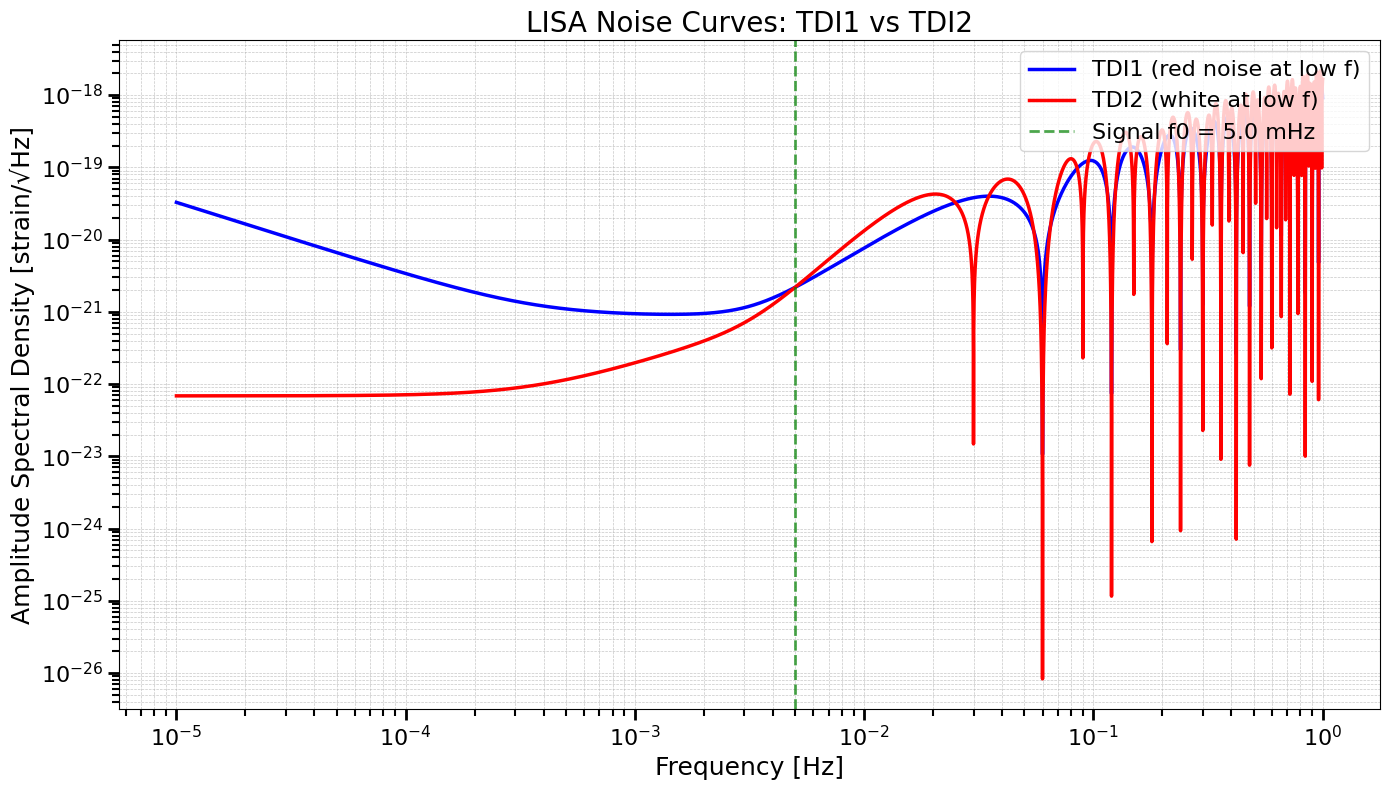

✓ TDI1: Red noise dominates at low frequencies
✓ TDI2: Better low-frequency performance, stronger high-frequency noise


In [116]:
# Generate frequency array for PSD visualization
freq_psd = np.logspace(-5, 0, 10000)

# Compute PSDs
psd_tdi1 = noise_PSD(freq_psd, TDI='TDI1')
psd_tdi2 = noise_PSD(freq_psd, TDI='TDI2')

# Plot
fig, ax = plt.subplots(1, 1, figsize=[14, 8])

ax.loglog(freq_psd, np.sqrt(psd_tdi1), 'b-', linewidth=2.5, label='TDI1 (red noise at low f)')
ax.loglog(freq_psd, np.sqrt(psd_tdi2), 'r-', linewidth=2.5, label='TDI2 (white at low f)')
ax.axvline(f0_ex, color='green', linestyle='--', alpha=0.7, linewidth=2, label=f'Signal f0 = {f0_ex*1e3:.1f} mHz')

ax.set_xlabel('Frequency [Hz]', fontsize=18)
ax.set_ylabel('Amplitude Spectral Density [strain/√Hz]', fontsize=18)
ax.set_title('LISA Noise Curves: TDI1 vs TDI2', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=16, length=8, width=2)
ax.tick_params(axis='both', which='minor', labelsize=14, length=5, width=1.5)
ax.legend(loc="upper right", fontsize=16)
ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

plt.tight_layout()
plt.show()

print("✓ TDI1: Red noise dominates at low frequencies")
print("✓ TDI2: Better low-frequency performance, stronger high-frequency noise")

# Build Noise Covariance Matrices

Generate the non-diagonal covariance matrices for modulated noise processes using both TDI1 and TDI2 noise curves.

In [121]:
# Prepare two-sided PSDs (fftshifted)
PSD_TDI1 = noise_PSD(freq_bin, TDI="TDI1")
PSD_TDI1[0] = PSD_TDI1[1]

PSD_TDI2 = noise_PSD(freq_bin, TDI="TDI2")
PSD_TDI2[0] = PSD_TDI2[1]

print("Computing covariance matrices using fast FFT method...")
print("This may take a moment for large N...")

# Compute covariance matrices (fast method)
import time
start = time.time()
Cov_Matrix_TDI1_modulated = noise_covariance_w_pos(PSD_TDI1, w_t, delta_t, diag=10) 
elapsed_tdi1 = time.time() - start

start = time.time()
Cov_Matrix_TDI2_modulated = noise_covariance_w_pos(PSD_TDI2, w_t, delta_t, diag=10)
elapsed_tdi2 = time.time() - start

print(f"✓ TDI1 covariance matrix computed in {elapsed_tdi1:.2f} s")
print(f"✓ TDI2 covariance matrix computed in {elapsed_tdi2:.2f} s")
print(f"\nMatrix properties:")
print(f"  Shape: {Cov_Matrix_TDI1_modulated.shape}")
print(f"  Hermitian: {np.allclose(Cov_Matrix_TDI1_modulated, Cov_Matrix_TDI1_modulated.conj().T)}")
print(f"  Memory usage: {Cov_Matrix_TDI1_modulated.nbytes / 1024**2:.1f} MB per matrix")

Computing covariance matrices using fast FFT method...
This may take a moment for large N...
✓ TDI1 covariance matrix computed in 0.03 s
✓ TDI2 covariance matrix computed in 0.03 s

Matrix properties:
  Shape: (2049, 2049)
  Hermitian: True
  Memory usage: 64.1 MB per matrix


# Build Stationary (Mismodeled) Covariance Matrices

For comparison, build diagonal covariance matrices assuming stationary noise (ignoring modulation).

In [122]:
# Stationary covariance: diagonal matrix with PSD/2Δf on diagonal
Cov_Matrix_TDI1_stationary = np.diag(N*PSD_TDI1 / (2 * delta_t))
Cov_Matrix_TDI2_stationary = np.diag(N*PSD_TDI2 / (2 * delta_t))

print("✓ Stationary (diagonal) covariance matrices constructed")
print(f"\nStationary assumption:")
print(f"  Assumes uncorrelated frequency bins")
print(f"  Σ_ij = δ_ij * S_n(f_i) / (2Δf)")
print(f"  Valid only for stationary processes")

✓ Stationary (diagonal) covariance matrices constructed

Stationary assumption:
  Assumes uncorrelated frequency bins
  Σ_ij = δ_ij * S_n(f_i) / (2Δf)
  Valid only for stationary processes


In [123]:
SNR_TDI1 = ((4 * delta_t)/N * np.sum(np.abs(signal_true_fft)**2 / (PSD_TDI1)))**(1/2)
SNR_TDI2 = ((4 * delta_t)/N * np.sum(np.abs(signal_true_fft)**2 / (PSD_TDI2)))**(1/2)

print(f"\nSNR² under stationary assumption (TDI1): {SNR_TDI1:.2f}")
print(f"\nSNR² under stationary assumption (TDI1): {SNR_TDI2:.2f}")


SNR² under stationary assumption (TDI1): 35.12

SNR² under stationary assumption (TDI1): 30.50


# Visualize Covariance Matrix Structure

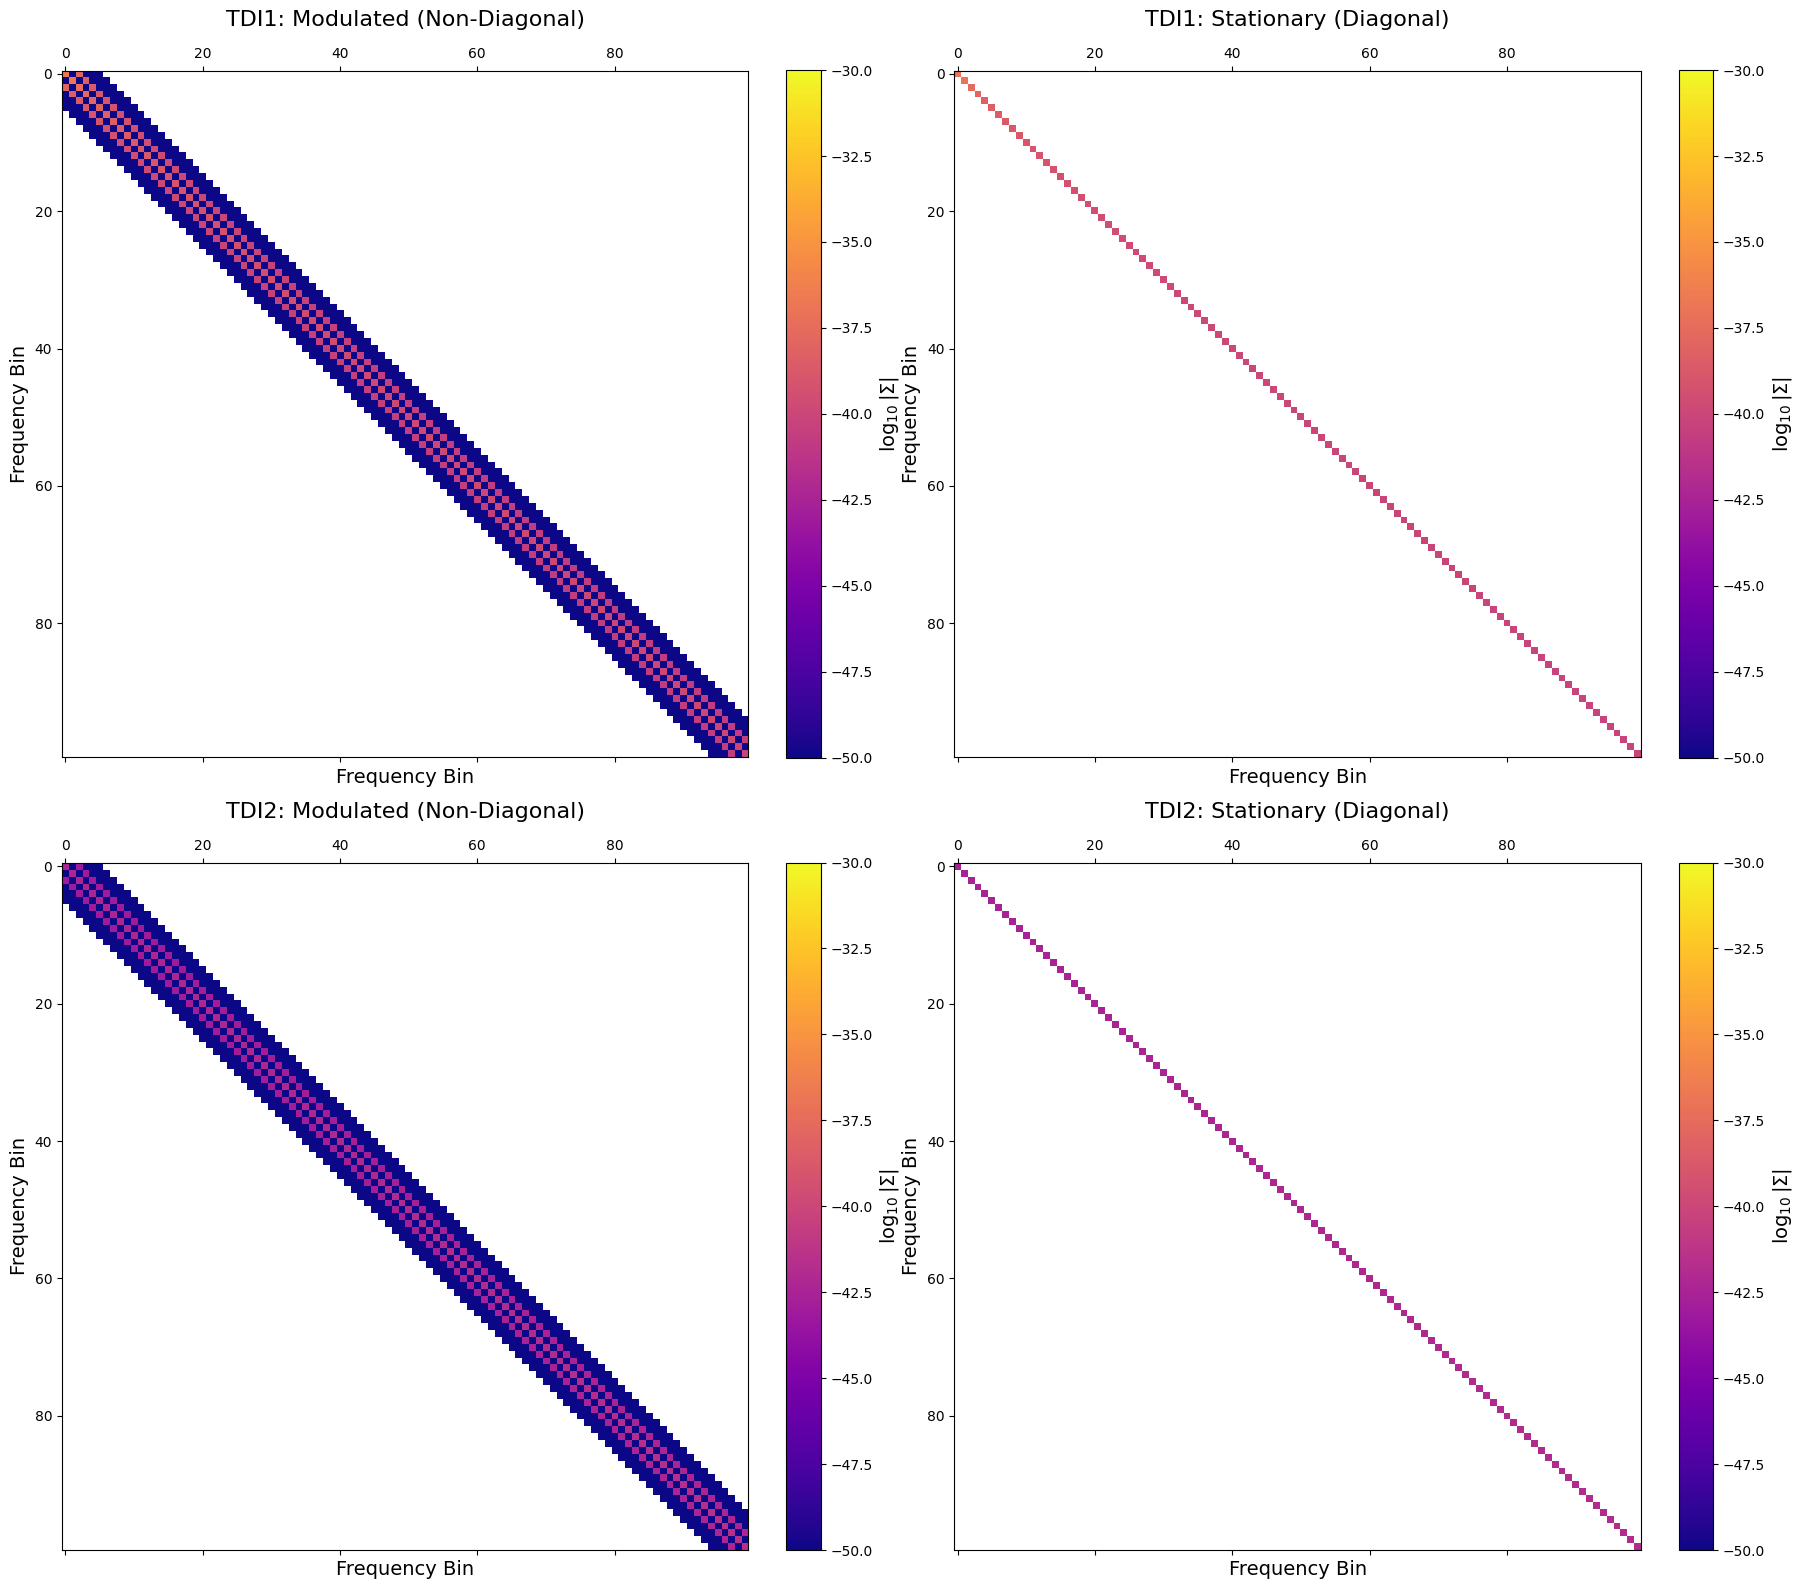

Key observations:
  • Modulated matrices show off-diagonal band structure
  • Stationary matrices are purely diagonal
  • Off-diagonal terms represent frequency coupling from modulation


In [124]:
# Plot subset of covariance matrices
N_plot = 100  # Number of bins to visualize

fig, axes = plt.subplots(2, 2, figsize=[18, 16])

# TDI1 - Modulated
mat1 = axes[0, 0].matshow(np.log10(np.abs(Cov_Matrix_TDI1_modulated[:N_plot, :N_plot])), 
                           cmap='plasma', vmin=-50, vmax=-30)
axes[0, 0].set_title('TDI1: Modulated (Non-Diagonal)', fontsize=16, pad=15)
axes[0, 0].set_xlabel('Frequency Bin', fontsize=14)
axes[0, 0].set_ylabel('Frequency Bin', fontsize=14)
cbar1 = fig.colorbar(mat1, ax=axes[0, 0], fraction=0.046)
cbar1.set_label(r'$\log_{10}|\Sigma|$', fontsize=14)

# TDI1 - Stationary
mat2 = axes[0, 1].matshow(np.log10(np.abs(Cov_Matrix_TDI1_stationary[:N_plot, :N_plot])), 
                           cmap='plasma', vmin=-50, vmax=-30)
axes[0, 1].set_title('TDI1: Stationary (Diagonal)', fontsize=16, pad=15)
axes[0, 1].set_xlabel('Frequency Bin', fontsize=14)
axes[0, 1].set_ylabel('Frequency Bin', fontsize=14)
cbar2 = fig.colorbar(mat2, ax=axes[0, 1], fraction=0.046)
cbar2.set_label(r'$\log_{10}|\Sigma|$', fontsize=14)

# TDI2 - Modulated
mat3 = axes[1, 0].matshow(np.log10(np.abs(Cov_Matrix_TDI2_modulated[:N_plot, :N_plot])), 
                           cmap='plasma', vmin=-50, vmax=-30)
axes[1, 0].set_title('TDI2: Modulated (Non-Diagonal)', fontsize=16, pad=15)
axes[1, 0].set_xlabel('Frequency Bin', fontsize=14)
axes[1, 0].set_ylabel('Frequency Bin', fontsize=14)
cbar3 = fig.colorbar(mat3, ax=axes[1, 0], fraction=0.046)
cbar3.set_label(r'$\log_{10}|\Sigma|$', fontsize=14)

# TDI2 - Stationary
mat4 = axes[1, 1].matshow(np.log10(np.abs(Cov_Matrix_TDI2_stationary[:N_plot, :N_plot])), 
                           cmap='plasma', vmin=-50, vmax=-30)
axes[1, 1].set_title('TDI2: Stationary (Diagonal)', fontsize=16, pad=15)
axes[1, 1].set_xlabel('Frequency Bin', fontsize=14)
axes[1, 1].set_ylabel('Frequency Bin', fontsize=14)
cbar4 = fig.colorbar(mat4, ax=axes[1, 1], fraction=0.046)
cbar4.set_label(r'$\log_{10}|\Sigma|$', fontsize=14)

plt.tight_layout()
plt.show()

print("Key observations:")
print("  • Modulated matrices show off-diagonal band structure")
print("  • Stationary matrices are purely diagonal")
print("  • Off-diagonal terms represent frequency coupling from modulation")

# SNR Calculation: Correct vs Mismodeled

Compute SNR using:
1. **Correct covariance**: Non-diagonal modulated covariance
2. **Mismodeled covariance**: Diagonal stationary covariance

Formula: $\rho^2 = \boldsymbol{\tilde{h}}^\dagger \Sigma_N^{-1} \boldsymbol{\tilde{h}}$

In [125]:
from scipy.sparse.linalg import spsolve
from scipy.sparse import csc_matrix 

def precompute_factorization(Sigma):
    """Pre-factorize Hermitian matrix for multiple solves."""
    if not hasattr(Sigma, 'format'):
        Sigma_sparse = csc_matrix(Sigma)
    else:
        Sigma_sparse = Sigma
    
    # For Hermitian matrices, could use specialized factorization
    # scipy doesn't have direct Cholesky for complex Hermitian, 
    # but LU is still efficient and cached
    return Sigma_sparse

def fast_inner_product(a, b, Sigma_sparse):
    """Fast inner product using pre-converted sparse matrix."""
    x = spsolve(Sigma_sparse, b)
    return 2*np.real(np.vdot(a, x))

Cov_Matrix_TDI1_modulated_sparse = precompute_factorization(Cov_Matrix_TDI1_modulated)
Cov_Matrix_TDI2_modulated_sparse = precompute_factorization(Cov_Matrix_TDI2_modulated)

Cov_Matrix_TDI1_stationary_sparse = precompute_factorization(Cov_Matrix_TDI1_stationary)
Cov_Matrix_TDI2_stationary_sparse = precompute_factorization(Cov_Matrix_TDI2_stationary)

In [126]:
SNR2_TDI1_mod = fast_inner_product(signal_true_fft, signal_true_fft, Cov_Matrix_TDI1_modulated_sparse)
print(f"SNR_TDI1_fast = {SNR2_TDI1_mod**0.5} (fast method with modulation)")

SNR_TDI1_fast = 28.79181444469179 (fast method with modulation)


In [128]:

# SNR² = h† Σ⁻¹ h
SNR2_TDI1_mod = fast_inner_product(signal_true_fft, signal_true_fft, Cov_Matrix_TDI1_modulated_sparse) 
SNR2_TDI2_mod = fast_inner_product(signal_true_fft, signal_true_fft, Cov_Matrix_TDI2_modulated_sparse) 

print(f"✓ TDI1 SNR (correct): {np.sqrt(SNR2_TDI1_mod)}")
print(f"✓ TDI2 SNR (correct): {np.sqrt(SNR2_TDI2_mod)}")

# Compute SNR with mismodeled (stationary) covariance
print("\nComputing SNR with mismodeled stationary covariance...")

SNR2_TDI1_stat = fast_inner_product(signal_true_fft, signal_true_fft, Cov_Matrix_TDI1_stationary_sparse)
SNR2_TDI2_stat = fast_inner_product(signal_true_fft, signal_true_fft, Cov_Matrix_TDI2_stationary_sparse)

print(f"✓ TDI1 SNR (stationary): {np.sqrt(SNR2_TDI1_stat)}")
print(f"✓ TDI2 SNR (stationary): {np.sqrt(SNR2_TDI2_stat)}")


✓ TDI1 SNR (correct): 28.79181444469179
✓ TDI2 SNR (correct): 25.137860800426918

Computing SNR with mismodeled stationary covariance...
✓ TDI1 SNR (stationary): 35.118006973595264
✓ TDI2 SNR (stationary): 30.49571504188533


In [129]:
def gen_noise(variance_f, seed=42, w_t=1.0, time_domain=False):
    """
    Generate colored noise in frequency domain, optionally apply window and return in time domain.
    
    Parameters:
    - variance_f: Variance of noise in each frequency bin (array)
    - seed: Random seed for reproducibility
    - w_t: Window function in time domain (scalar 1.0 or array)
    - time_domain: If True, return time-domain noise; else frequency-domain
    
    Returns:
    - Noise realization (time or frequency domain depending on flag)
    """
    np.random.seed(seed)
    noise_imag = np.random.normal(0, np.sqrt(variance_f))   # Generate imaginary part
    noise_real = np.random.normal(0, np.sqrt(variance_f))   # Generate real part
    noise_f = noise_real + 1j * noise_imag

    # Ensure DC and Nyquist are real
    noise_f[0] = np.sqrt(2) * noise_f[0].real
    noise_f[-1] = np.sqrt(2) * noise_f[-1].real

    # Check if w_t is scalar (no modulation) or array (modulation)
    is_unmodulated = np.isscalar(w_t) and np.isclose(w_t, 1.0)
    
    if time_domain:
        # Return time-domain noise
        noise_t = np.fft.irfft(noise_f)
        if is_unmodulated:
            return noise_t
        else:
            # Apply modulation window in time domain
            return w_t * noise_t
    else:
        # Return frequency-domain noise
        if is_unmodulated:
            return noise_f
        else:
            # Apply modulation in time domain, then transform back
            noise_t = np.fft.irfft(noise_f)
            noise_t_w = w_t * noise_t
            noise_f_w = np.fft.rfft(noise_t_w)
            return noise_f_w

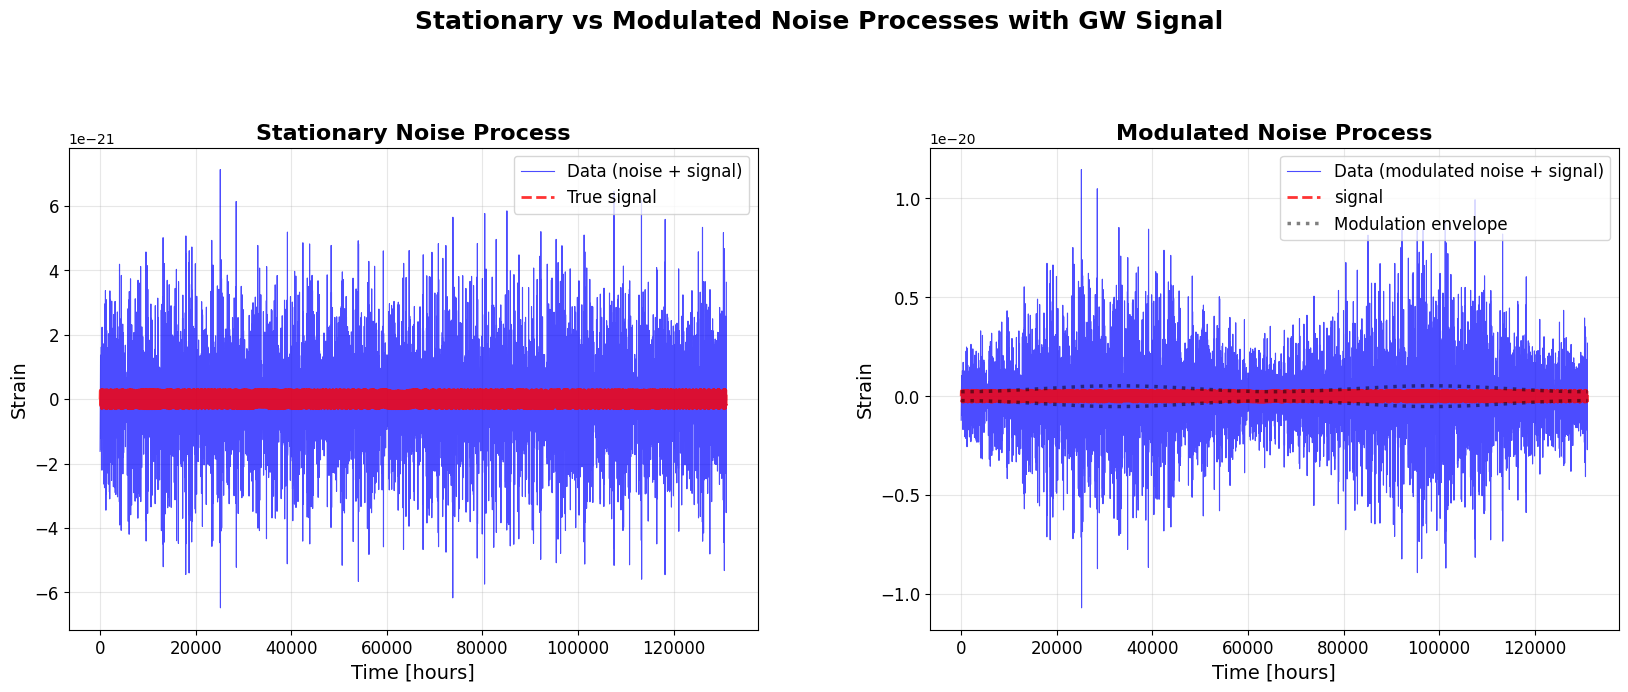

In [130]:

# Generate noise realizations and create modulated data

# Set seed for reproducibility
np.random.seed(42)

# 1. Generate stationary white noise in frequency domain
# For stationary case: generate noise with PSD, no modulation

variance_f_tdi2 = (N * PSD_TDI2/(4*delta_t))   # Compute variance of the noise (of on gapped noise) [shifted]

# Convert to time domain
noise_stationary_t = gen_noise(variance_f_tdi2, seed=42, w_t=1.0, time_domain=True)
noise_modulated_t = gen_noise(variance_f_tdi2, seed=42, w_t=w_t, time_domain=True)

# noise_modulated_t = w_t * noise_stationary_t
# 3. Create data with signal
# For stationary: add unmodulated signal
data_stationary_t = noise_stationary_t + signal_true_pad

# For modulated: modulate noise in time domain and add modulated signal
data_modulated_t = noise_modulated_t + signal_true_pad


# 5. Plotting
fig = plt.figure(figsize=[20, 12])
gs = fig.add_gridspec(2, 2, height_ratios=[1.5, 1], hspace=0.3, wspace=0.25)

# Top left: Stationary noise + signal
ax1 = fig.add_subplot(gs[0, 0])
time_hours = t_pad[:one_hour*3] / 3600  # Show first 3 hours
ax1.plot(t_pad, data_stationary_t, 'b-', alpha=0.7, linewidth=0.8, label='Data (noise + signal)')
ax1.plot(t_pad, signal_true_pad, 'r--', linewidth=2, alpha=0.8, label='True signal')
ax1.set_xlabel('Time [hours]', fontsize=14)
ax1.set_ylabel('Strain', fontsize=14)
ax1.set_title('Stationary Noise Process', fontsize=16, fontweight='bold')
ax1.legend(fontsize=12, loc='upper right')
ax1.grid(True, alpha=0.3)
ax1.tick_params(labelsize=12)

# Top right: Modulated noise + signal
ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(t_pad, data_modulated_t, 'b-', alpha=0.7, linewidth=0.8, label='Data (modulated noise + signal)')
ax2.plot(t_pad, signal_true_pad, 'r--', linewidth=2, alpha=0.8, label='signal')
# Overlay modulation envelope
envelope = w_t * np.max(np.abs(signal_true_pad))
ax2.plot(t_pad, envelope, 'k:', linewidth=2.5, alpha=0.5, label='Modulation envelope')
ax2.plot(t_pad, -envelope, 'k:', linewidth=2.5, alpha=0.5)
ax2.set_xlabel('Time [hours]', fontsize=14)
ax2.set_ylabel('Strain', fontsize=14)
ax2.set_title('Modulated Noise Process', fontsize=16, fontweight='bold')
ax2.legend(fontsize=12, loc='upper right')
ax2.grid(True, alpha=0.3)
ax2.tick_params(labelsize=12)


plt.suptitle('Stationary vs Modulated Noise Processes with GW Signal', 
             fontsize=18, fontweight='bold', y=0.995)
plt.show()


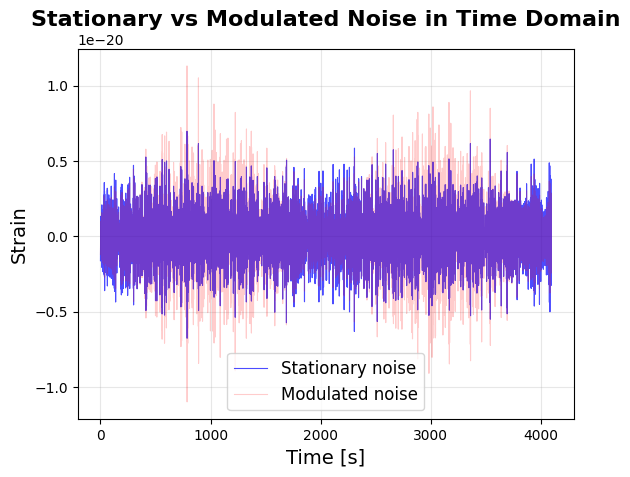

In [131]:
plt.plot(noise_stationary_t, 'b-', alpha=0.7, linewidth=0.8, label='Stationary noise')
plt.plot(noise_modulated_t, 'r-', alpha=0.2, linewidth=0.8, label='Modulated noise')
plt.xlabel('Time [s]', fontsize=14)
plt.ylabel('Strain', fontsize=14)
plt.title('Stationary vs Modulated Noise in Time Domain', fontsize=16, fontweight='bold')
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)

# Maximum Likelihood Estimation

Compute MLE for amplitude parameter using correct and mismodeled covariances.

For a template $h(a)$ linear in amplitude $a$, the MLE is:
$$\hat{a}_{\text{ML}} = \frac{\boldsymbol{d}^\dagger \Sigma^{-1} \boldsymbol{h}(a=1)}{\boldsymbol{h}^\dagger(a=1) \Sigma^{-1} \boldsymbol{h}(a=1)}$$

In [132]:
# Unnormalized template (a=1)
seed_number = 2
normed_template = signal_true_fft / a_ex
noise_f_tdi2_modulated = gen_noise(variance_f_tdi2, seed=seed_number, w_t = w_t, time_domain = False)

data_TDI2_fft = signal_true_fft + noise_f_tdi2_modulated

# MLE with CORRECT covariance (TDI2)

numerator_TDI2_correct = fast_inner_product(data_TDI2_fft, normed_template, Cov_Matrix_TDI2_modulated_sparse)
denominator_TDI2_correct = fast_inner_product(normed_template, normed_template, Cov_Matrix_TDI2_modulated_sparse)
a_ML_TDI2_correct = numerator_TDI2_correct / denominator_TDI2_correct

# MLE with MISMODELED covariance (TDI2)
numerator_TDI2_mismodel = fast_inner_product(data_TDI2_fft, normed_template, Cov_Matrix_TDI2_stationary_sparse)
denominator_TDI2_mismodel = fast_inner_product(normed_template, normed_template, Cov_Matrix_TDI2_stationary_sparse)
a_ML_TDI2_mismodel = numerator_TDI2_mismodel / denominator_TDI2_mismodel

# Fisher Matrix precision (correct covariance)
sigma_a_TDI2_correct = 1 / np.sqrt(np.real(denominator_TDI2_correct))

print(f"Maximum Likelihood Estimates (single realization, seed={seed_number}):")

print(f"\nTDI2:")
print(f"  True amplitude: a = {a_ex:.4f}")
print(f"  MLE (correct):  â = {a_ML_TDI2_correct:.4f} ")
print(f"  MLE (mismodel): â = {a_ML_TDI2_mismodel:.4f}")
print(f"  Fisher σ(a):    σ = {sigma_a_TDI2_correct:.4f}")

Maximum Likelihood Estimates (single realization, seed=2):

TDI2:
  True amplitude: a = 1.0000
  MLE (correct):  â = 0.9701 
  MLE (mismodel): â = 0.9670
  Fisher σ(a):    σ = 0.0398


# Likelihood Evaluation Over Parameter Grid

Evaluate log-likelihood over a range of amplitude values to visualize the likelihood function.

100%|██████████| 400/400 [00:00<00:00, 536.25it/s]


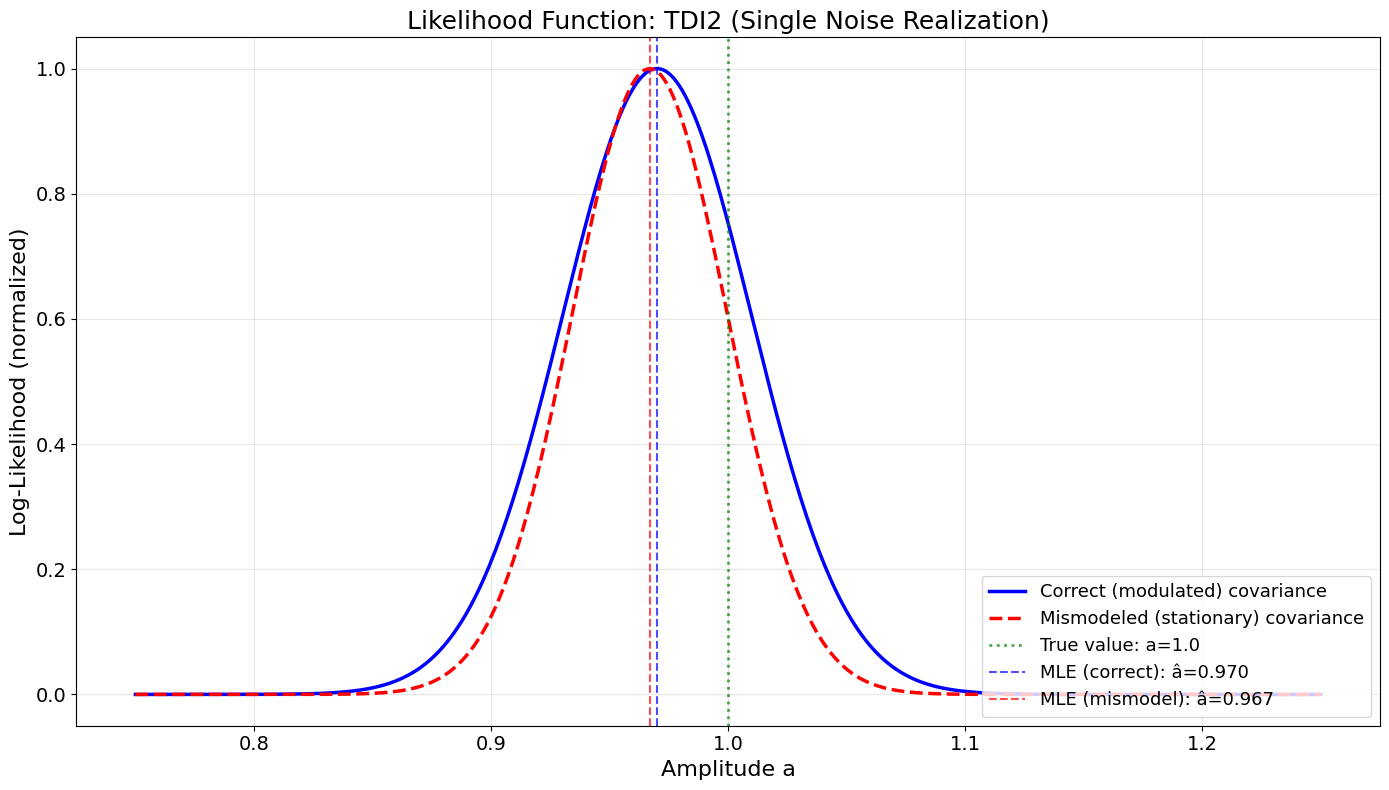

✓ Likelihood functions computed and visualized


<Figure size 640x480 with 0 Axes>

In [133]:
# Define amplitude grid
a_range = np.linspace(a_ex-0.25, a_ex + 0.25, 400)

# Compute log-likelihood for TDI2 (incorrect/correct covariance)
llike_TDI2_correct = []
llike_TDI2_mismodel = []
for a_test in tqdm(a_range):
    h_test = a_test * normed_template
    residual = data_TDI2_fft - h_test # Remember, data = h + n with n modified. Not stationary

    llike_val_TDI2_correct = -0.5 * fast_inner_product(residual, residual, Cov_Matrix_TDI2_modulated_sparse)
    llike_val_TDI2_mismodel = -0.5 * fast_inner_product(residual, residual, Cov_Matrix_TDI2_stationary_sparse)

    llike_TDI2_correct.append(llike_val_TDI2_correct)
    llike_TDI2_mismodel.append(llike_val_TDI2_mismodel)

# Normalize for better visualization
llike_TDI2_correct = np.array(llike_TDI2_correct)
llike_TDI2_correct -= np.max(llike_TDI2_correct)

llike_TDI2_mismodel = np.array(llike_TDI2_mismodel)
llike_TDI2_mismodel -= np.max(llike_TDI2_mismodel)

like_TDI2_correct = np.exp(llike_TDI2_correct)
like_TDI2_mismodel = np.exp(llike_TDI2_mismodel)

# Plot
fig, ax = plt.subplots(1, 1, figsize=[14, 8])

ax.plot(a_range, like_TDI2_correct, 'b-', linewidth=2.5, label='Correct (modulated) covariance')
ax.plot(a_range, like_TDI2_mismodel, 'r--', linewidth=2.5, label='Mismodeled (stationary) covariance')
ax.axvline(a_ex, color='green', linestyle=':', linewidth=2, alpha=0.7, label=f'True value: a={a_ex}')
ax.axvline(a_ML_TDI2_correct, color='blue', linestyle='--', linewidth=1.5, alpha=0.7, label=f'MLE (correct): â={a_ML_TDI2_correct:.3f}')
ax.axvline(a_ML_TDI2_mismodel, color='red', linestyle='--', linewidth=1.5, alpha=0.7, label=f'MLE (mismodel): â={a_ML_TDI2_mismodel:.3f}')

ax.set_xlabel('Amplitude a', fontsize=16)
ax.set_ylabel('Log-Likelihood (normalized)', fontsize=16)
ax.set_title('Likelihood Function: TDI2 (Single Noise Realization)', fontsize=18)
ax.legend(fontsize=13, loc='lower right')
ax.grid(True, alpha=0.3)
ax.tick_params(labelsize=14)

plt.tight_layout()
plt.show()
plt.clf()
print("✓ Likelihood functions computed and visualized")

# Monte Carlo Analysis: Bias and Precision Assessment

Generate many noise realizations and compute MLE for each to assess:
1. **Bias**: Does the estimator converge to the true value on average?
2. **Precision**: Is the scatter consistent with Fisher matrix predictions?
3. **Mismodeling impact**: How does assuming stationary noise affect results?

In [134]:
# Monte Carlo parameters
n_realizations = 2000  # Number of noise realizations
print(f"Running Monte Carlo with {n_realizations} realizations...")
print("This will take a few minutes...\n")

# Storage for results
MLE_TDI2_correct_list = []
MLE_TDI2_mismodel_list = []

# Precompute denominators (template-dependent, noise-independent)
denom_TDI2_correct = fast_inner_product(normed_template, normed_template, Cov_Matrix_TDI2_modulated_sparse)
denom_TDI2_mismodel = fast_inner_product(normed_template, normed_template, Cov_Matrix_TDI2_stationary_sparse)

# Monte Carlo loop
for i in tqdm(range(n_realizations)):
    # Generate noise
    noise_f_tdi2_modulated = gen_noise(variance_f_tdi2, seed=i+1000, w_t = w_t, time_domain = False) 
    # Create data
    data_TDI2 = signal_true_fft + noise_f_tdi2_modulated
    
    # MLE for TDI2
    numer_TDI2_correct = fast_inner_product(data_TDI2, normed_template, Cov_Matrix_TDI2_modulated_sparse)
    a_ML_TDI2_correct = numer_TDI2_correct / denom_TDI2_correct
    MLE_TDI2_correct_list.append(a_ML_TDI2_correct)

    numer_TDI2_mismodel = fast_inner_product(data_TDI2, normed_template, Cov_Matrix_TDI2_stationary_sparse)
    a_ML_TDI2_mismodel = numer_TDI2_mismodel / denom_TDI2_mismodel
    MLE_TDI2_mismodel_list.append(a_ML_TDI2_mismodel)

# Convert to arrays
MLE_TDI2_correct_array = np.array(MLE_TDI2_correct_list)
MLE_TDI2_mismodel_array = np.array(MLE_TDI2_mismodel_list)

print(f"\n✓ Monte Carlo complete: {n_realizations} realizations processed")

Running Monte Carlo with 2000 realizations...
This will take a few minutes...



100%|██████████| 2000/2000 [00:03<00:00, 507.68it/s]


✓ Monte Carlo complete: 2000 realizations processed


# Statistical Analysis of Monte Carlo Results

In [135]:
# Compute statistics
# TDI2
mean_TDI2_correct = np.mean(MLE_TDI2_correct_array)
std_TDI2_correct = np.std(MLE_TDI2_correct_array)
bias_TDI2_correct = mean_TDI2_correct - a_ex

mean_TDI2_mismodel = np.mean(MLE_TDI2_mismodel_array)
std_TDI2_mismodel = np.std(MLE_TDI2_mismodel_array)
bias_TDI2_mismodel = mean_TDI2_mismodel - a_ex

# Fisher matrix predictions
Fisher_sigma_TDI2 = 1 / np.sqrt(denom_TDI2_correct)

print(f"{'='*80}")
print(f"MONTE CARLO RESULTS ({n_realizations} realizations)")
print(f"{'='*80}")

print(f"\nTDI2 - CORRECT COVARIANCE:")
print(f"  Mean:          {mean_TDI2_correct:.6f}")
print(f"  Std:           {std_TDI2_correct:.6f}")
print(f"  Fisher σ:      {Fisher_sigma_TDI2:.6f}")
print(f"  Bias:          {bias_TDI2_correct:.6f} ({bias_TDI2_correct/a_ex*100:+.3f}%)")
print(f"  Std/Fisher:    {std_TDI2_correct/Fisher_sigma_TDI2:.4f} (should be ~1.0)")

print(f"\nTDI2 - MISMODELED COVARIANCE:")
print(f"  Mean:          {mean_TDI2_mismodel:.6f}")
print(f"  Std:           {std_TDI2_mismodel:.6f}")
print(f"  Fisher σ:      {Fisher_sigma_TDI2:.6f}")
print(f"  Bias:          {bias_TDI2_mismodel:.6f} ({bias_TDI2_mismodel/a_ex*100:+.3f}%)")
print(f"  Std/Fisher:    {std_TDI2_mismodel/Fisher_sigma_TDI2:.4f}")

print(f"\n{'='*80}")
print(f"KEY FINDINGS:")
print(f"{'='*80}")
print(f"Correct covariance → unbiased estimates with Fisher-predicted precision")
print(f"Mismodeled covariance → potential bias and incorrect precision estimates")

MONTE CARLO RESULTS (2000 realizations)

TDI2 - CORRECT COVARIANCE:
  Mean:          0.999869
  Std:           0.036811
  Fisher σ:      0.039781
  Bias:          -0.000131 (-0.013%)
  Std/Fisher:    0.9254 (should be ~1.0)

TDI2 - MISMODELED COVARIANCE:
  Mean:          0.999894
  Std:           0.041762
  Fisher σ:      0.039781
  Bias:          -0.000106 (-0.011%)
  Std/Fisher:    1.0498

KEY FINDINGS:
Correct covariance → unbiased estimates with Fisher-predicted precision
Mismodeled covariance → potential bias and incorrect precision estimates


In [140]:
# Compute mismodeling matrix for amplitude parameter
# This quantifies the error from using stationary covariance when data has modulated noise

# Get inverse of stationary (mismodeled) covariance
Cov_Matrix_TDI2_stationary_inv = np.linalg.inv(Cov_Matrix_TDI2_stationary)

# Compute mismodeling matrix: how much the incorrect covariance affects parameter estimation
# Formula: (2 * a²/SNR²_mismodel) * Re[h† Σ_stat^-1 Σ_true Σ_stat^-1 h]
gamma_mismodel = SNR2_TDI2_stat / (a_ex**2)

mis_modelling_matrix = 2 * gamma_mismodel **(-2) * np.real(
    signal_true_fft.conj() @ 
    Cov_Matrix_TDI2_stationary_inv @ 
    Cov_Matrix_TDI2_modulated @ 
    Cov_Matrix_TDI2_stationary_inv @ 
    signal_true_fft
)

# Compute true Fisher information with correct covariance
gamma_correct_inv = (SNR2_TDI2_mod / (a_ex**2))**-1

# Relative mismodeling factor
Upsilon_aa = mis_modelling_matrix / gamma_correct_inv

print(f"Mismodeling matrix for amplitude: {mis_modelling_matrix:.6f}")
print(f"Relative mismodeling factor Υ_aa: {Upsilon_aa:.6f}")
print(f"Precision in parameter a is: {gamma_correct_inv**(1/2):.6f}")
print(f"\nInterpretation:")
print(f"  Υ_aa ≈ 1.0 → negligible mismodeling bias")
print(f"  Υ_aa > 1.0 → mismodeled errors underestimated")
print(f"  Υ_aa < 1.0 → mismodeled errors overestimated")


mismodelling_sigma_val = mis_modelling_matrix**(1/2)

print(f"True accuracy in parameters is equal to {mismodelling_sigma_val:.6f}")
print(f"From monte-carloing the noise biases, the true accuracy in parameters is equal to {std_TDI2_mismodel:.6f} ")

Mismodeling matrix for amplitude: 0.001719
Relative mismodeling factor Υ_aa: 1.086348
Precision in parameter a is: 0.039781

Interpretation:
  Υ_aa ≈ 1.0 → negligible mismodeling bias
  Υ_aa > 1.0 → mismodeled errors underestimated
  Υ_aa < 1.0 → mismodeled errors overestimated
True accuracy in parameters is equal to 0.041463
From monte-carloing the noise biases, the true accuracy in parameters is equal to 0.041762 


# Visualize Monte Carlo Distributions

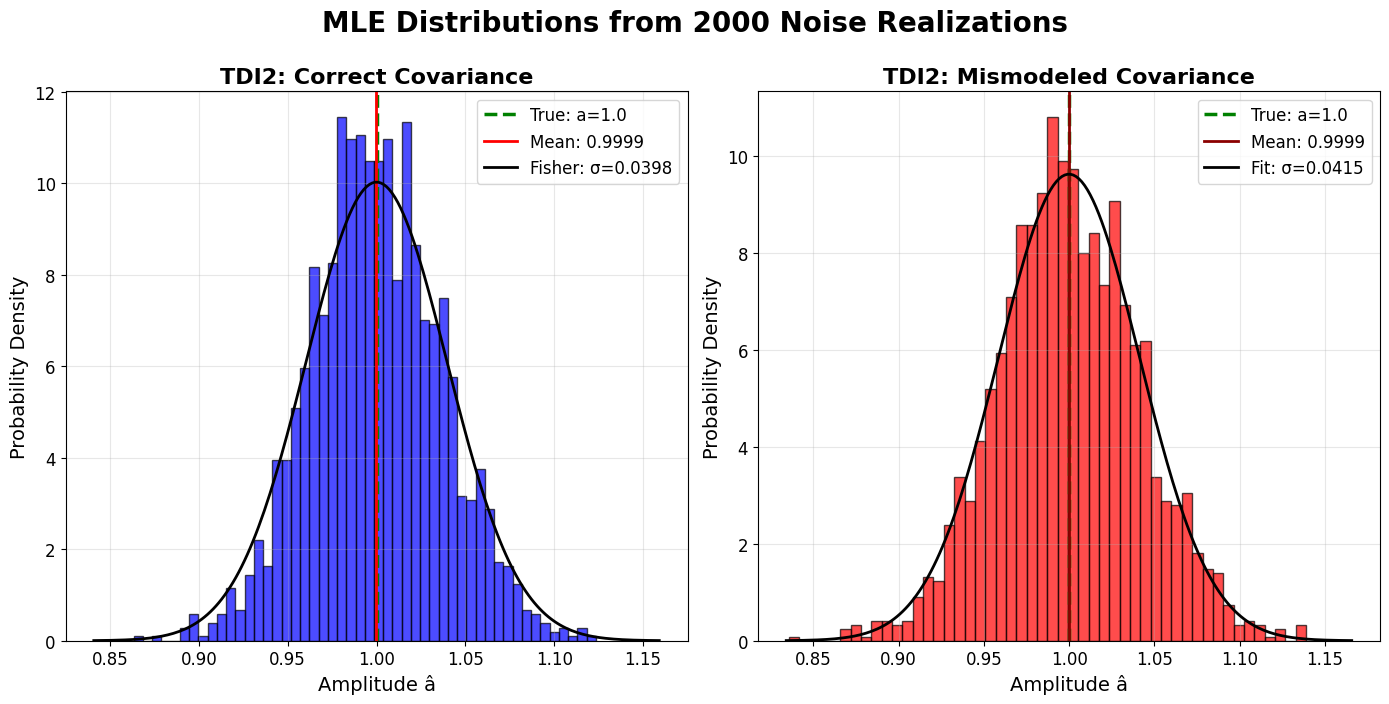

✓ Histograms show MLE distributions match Fisher predictions when covariance is correct


In [139]:
fig, axes = plt.subplots(1, 2, figsize=[14, 7])

# TDI2 - Correct
axes[0].hist(MLE_TDI2_correct_array, bins=50, alpha=0.7, color='blue', edgecolor='black', density=True)
axes[0].axvline(a_ex, color='green', linestyle='--', linewidth=2.5, label=f'True: a={a_ex}')
axes[0].axvline(mean_TDI2_correct, color='red', linestyle='-', linewidth=2, label=f'Mean: {mean_TDI2_correct:.4f}')
x_range = np.linspace(a_ex - 4*Fisher_sigma_TDI2, a_ex + 4*Fisher_sigma_TDI2, 200)
gaussian = (1/(Fisher_sigma_TDI2*np.sqrt(2*np.pi))) * np.exp(-0.5*((x_range-a_ex)/Fisher_sigma_TDI2)**2)
axes[0].plot(x_range, gaussian, 'k-', linewidth=2, label=f'Fisher: σ={Fisher_sigma_TDI2:.4f}')
axes[0].set_xlabel('Amplitude â', fontsize=14)
axes[0].set_ylabel('Probability Density', fontsize=14)
axes[0].set_title('TDI2: Correct Covariance', fontsize=16, fontweight='bold')
axes[0].legend(fontsize=12)
axes[0].grid(True, alpha=0.3)
axes[0].tick_params(labelsize=12)

# TDI2 - Mismodeled
axes[1].hist(MLE_TDI2_mismodel_array, bins=50, alpha=0.7, color='red', edgecolor='black', density=True)
axes[1].axvline(a_ex, color='green', linestyle='--', linewidth=2.5, label=f'True: a={a_ex}')
axes[1].axvline(mean_TDI2_mismodel, color='darkred', linestyle='-', linewidth=2, label=f'Mean: {mean_TDI2_mismodel:.4f}')
x_range = np.linspace(mean_TDI2_mismodel - 4*mismodelling_sigma_val, mean_TDI2_mismodel + 4*mismodelling_sigma_val, 200)
gaussian = (1/(mismodelling_sigma_val*np.sqrt(2*np.pi))) * np.exp(-0.5*((x_range-mean_TDI2_mismodel)/mismodelling_sigma_val)**2)
axes[1].plot(x_range, gaussian, 'k-', linewidth=2, label=f'Fit: σ={mismodelling_sigma_val:.4f}')
axes[1].set_xlabel('Amplitude â', fontsize=14)
axes[1].set_ylabel('Probability Density', fontsize=14)
axes[1].set_title('TDI2: Mismodeled Covariance', fontsize=16, fontweight='bold')
axes[1].legend(fontsize=12)
axes[1].grid(True, alpha=0.3)
axes[1].tick_params(labelsize=12)

plt.suptitle(f'MLE Distributions from {n_realizations} Noise Realizations', fontsize=20, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

print("✓ Histograms show MLE distributions match Fisher predictions when covariance is correct")